In [1]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import math as math
from scipy.stats import chisquare

In [256]:
def powerlaw(r, s0, b):  
    # r0 no es variable aleatoria
    r0 = 300
    return s0*(r0/r)**(b)

def baricentro(signal,det_pos,umbral):
    sum_s = 0
    bari_x = 0
    bari_y = 0
    for i in range(len(signal)):
        if signal[i] > umbral:
            bari_x += signal[i]*det_pos[i][0]
            bari_y += signal[i]*det_pos[i][1]
            sum_s  += signal[i]            
    return(bari_x/sum_s,bari_y/sum_s)
    

#estimacion inicial del core es el baricentro

def funcion_costo2(theta,x_pos,y_pos,signal_sim,zenith,azimuth,ysigma):

        s0 = theta[0]
        b = theta[1]
        x_core = theta[2]
        y_core = theta[3]
        
        costo = np.zeros_like(s0)

        for (dist_x,dist_y,y1,sigma1) in zip(x_pos,y_pos,signal_sim,ysigma):
            
            dist = getDistances(dist_x,dist_y,x_core,y_core,zenith,azimuth)[0]
            yfit = powerlaw(dist, s0, b)
            residuo = y1 - yfit
            z = (residuo / sigma1)
            costo += z*z

        return costo
    
costo2 = lambda theta: funcion_costo2(theta,x_det,y_det,y_random1,zenith,azimuth,sigma) 

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point

def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return (distances,axisProjections,groundDistances)

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)

poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
detectores_pos = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0],[0,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5,0] , [-375,-375,0,375,375,0,0]
centro = (0,0)
#x_det = np.zeros(len(detectores_pos))
#y_det = np.zeros(len(detectores_pos))
#for i in range(len(detectores_pos)):
#    x_det[i] = detectores_pos[i][0]
#    y_det[i] = detectores_pos[i][1]

In [ ]:
#Defino parametros de LDF 
r0 = 300 #metros 
s0 = 35 #VEM
angulo = 0
zenith = simZenith(-angulo,angulo)[0]
azimuth = simZenith(-angulo,angulo)[1]
b = 2.1    

#Genero el punto random
random_point = in_hex(poligono)

#calculo las distancias entre el evento y los 7 detectores.
distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
r = np.asarray(distancias[0])

signal = powerlaw(r,s0,b)
sigma_signal = np.sqrt(signal)

#Hago el ajuste y defino la semilla inicial
y_random = np.random.normal(signal,sigma_signal,size = len(signal)) #signal
y_random = y_random[y_random > 2]
sigma = np.sqrt(y_random)

core_est_x = baricentro(y_random,detectores_pos)[0] 
core_est_y = baricentro(y_random,detectores_pos)[1] 

In [ ]:
res = minimize(costo2, x0=(30,1,core_est_x,core_est_y))
#print(res)
print('Minimize results')
print("Parametros ajustados: ", res.x)
cova = 2*res.hess_inv
par_error = np.sqrt(np.diagonal(cova))
print('Errores de los parámetros', par_error)
print(cova)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(pointsx,pointsy)
plt.scatter(core_est_x,core_est_y,c='orange')
plt.scatter(random_point[0],random_point[1],s = 90,c='green')
plt.scatter(res.x[2],res.x[3],s = 90,c='red')
plt.grid()


In [ ]:
random_point,(res.x[2],res.x[3]),getDistances(random_point[0],random_point[1],res.x[2],res.x[3],0,0)[0],res.success

In [293]:
tries = 5000

#Core de la lluvia estimado
pos_res_x = np.zeros(tries)
pos_res_y = np.zeros(tries)

#Core de la lluvia simulado
puntos_x = []
puntos_y = []

signals = []

Falso = 0
Verd = 0

#Baricentro de los distintos eventos 
bar_x = np.zeros(tries)
bar_y = np.zeros(tries)

dist_core_sim = []

resultados_f = []
resultados_t = []

umbral = 2

for i in range(tries):
    
    #Genero el core de impacto de la lluvia
    random_point = in_hex(poligono)

    
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
    r = np.asarray(distancias[0])
    
    #Evalulo la señal 
    signal = powerlaw(r,s0,b)
    sigma_signal = np.sqrt(signal)

    #Randomizo la señal 
    y_random = np.random.normal(signal,sigma_signal,size = len(signal)) #señal simulada
    
    #Impongo filtro 
    y_random1 = y_random[y_random > umbral]
    sigma = np.sqrt(y_random1)
    
    #Defino la semilla inicial como el baricentro
    seed_x = baricentro(y_random1,detectores_pos,umbral)[0] 
    seed_y = baricentro(y_random1,detectores_pos,umbral)[1]
    
    #Inicio la minimizacion 
    res = minimize(costo2,x0=(30,1,seed_x,seed_y))
    
    
    if res.success == True:
        
        #Distancia entre core estimado y core simulado
        dist_core_sim.append(np.sqrt((res.x[2] - random_point[0])**2 + (res.x[3] - random_point[1])**2))

        #Me guardo el resultado de los distintos cores estimados
        pos_res_x[i] = res.x[2]
        pos_res_y[i] = res.x[3]
        
        Verd += 1
        
        bar_x[i] = seed_x
        bar_y[i] = seed_y
        
        #Me guardo los cores simulados 
        puntos_x.append(random_point[0])
        puntos_y.append(random_point[1])
        
        #Me guardo las señales filtradas
        signals.append(y_random1)
        
        #Me guardo el resultado de la simulacion
        resultados_t.append(res)
            
    if res.success == False:
        #Me guardo el resultado de la simulacion
        resultados_f.append(res)
        
        Falso += 1 
        
        #dif_est_x[i] = res.x[2]
        #dif_est_y[i] = res.x[3]
        #plt.figure(figsize=(8,8))
        #plt.scatter(pointsx,pointsy)
        #plt.scatter(core_est_x,core_est_y)
        #plt.scatter(random_point[0],random_point[1],s=90,c='green')
        #plt.scatter(res.x[2],res.x[3],s=90,c='red')
        #break
        

        

<ipython-input-256-fef69f8da66b>:37: RuntimeWarning: overflow encountered in double_scalars
  costo += z*z
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]
<ipython-input-256-fef69f8da66b>:37: RuntimeWarning: overflow encountered in double_scalars
  costo += z*z
<ipython-input-256-fef69f8da66b>:4: RuntimeWarning: overflow encountered in double_scalars
  return s0*(r0/r)**(b)
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]
<ipython-input-256-fef69f8da66b>:4: RuntimeWarning: overflow encountered in double_scalars
  return s0*(r0/r)**(b)
<ipython-input-256-fef69f8da66b>:4: RuntimeWarning: overflow encountered in double_scalars
  return s0*(r0/r)**(b)
/Users/gunitettamanti/opt/anaconda3/lib/python3.8/sit

(array([2.308e+03, 1.405e+03, 2.880e+02, 7.400e+01, 4.100e+01, 2.500e+01,
        1.700e+01, 2.100e+01, 1.000e+01, 1.800e+01, 1.700e+01, 1.600e+01,
        1.300e+01, 1.400e+01, 2.500e+01, 4.000e+01, 2.000e+01, 5.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([7.19477230e-02, 2.56101035e+01, 5.11482594e+01, 7.66864152e+01,
        1.02224571e+02, 1.27762727e+02, 1.53300883e+02, 1.78839038e+02,
        2.04377194e+02, 2.29915350e+02, 2.55453506e+02, 2.80991662e+02,
        3.06529818e+02, 3.32067973e+02, 3.57606129e+02, 3.83144285e+02,
        4.08682441e+02, 4.34220597e+02, 4.59758752e+02, 4.85296908e+02,
        5.108350

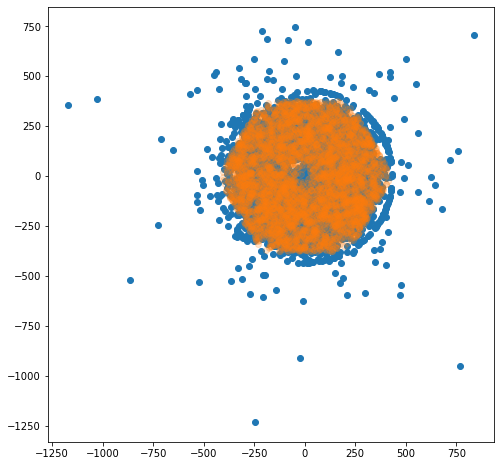

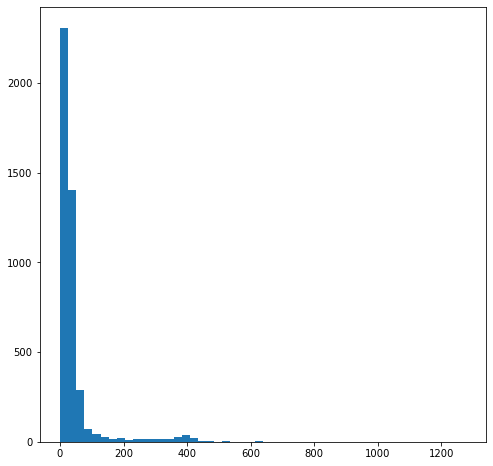

In [294]:
plt.figure(figsize=(8,8))
plt.scatter(pos_res_x,pos_res_y)
plt.scatter(puntos_x,puntos_y,alpha = 0.2)
plt.figure(figsize=(8,8))
plt.hist(error,bins=50)
#plt.xlim(0,1500)
#plt.ylim(0,2000)

In [295]:
Falso/(Verd+Falso)

0.137

In [296]:
maximo = np.where(dist_core_sim == np.max(dist_core_sim))

In [297]:
resultados_t[maximo[0][0]]

      fun: 1.7990541906276087
 hess_inv: array([[ 3.12381978e+03, -6.47093133e+00,  5.66017584e+02,
        -1.51133492e+03],
       [-6.47093133e+00,  1.47201498e-02, -1.17150154e+00,
         3.12955041e+00],
       [ 5.66017584e+02, -1.17150154e+00,  1.02590848e+02,
        -2.73871675e+02],
       [-1.51133492e+03,  3.12955041e+00, -2.73871675e+02,
         7.31222646e+02]])
      jac: array([-7.45058060e-08,  6.85453415e-06,  4.32133675e-07, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 1692
      nit: 222
     njev: 282
   status: 0
  success: True
        x: array([ 2.94372521e+04,  5.41121386e+00, -2.46530001e+02, -1.23077695e+03])

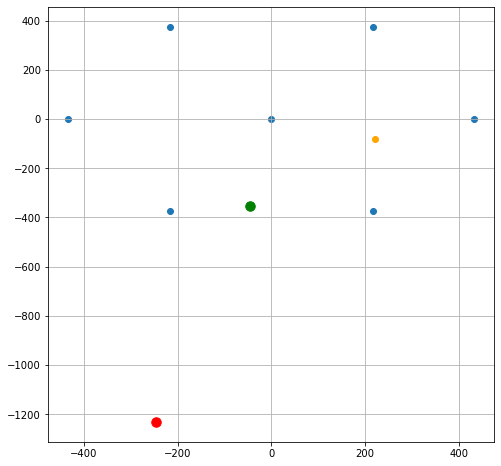

In [298]:
plt.figure(figsize=(8,8))
plt.scatter(pointsx,pointsy)
plt.scatter(bar_x[maximo[0][0]],bar_y[maximo[0][0]],c='orange')
plt.scatter(puntos_x[maximo[0][0]],puntos_y[maximo[0][0]],s = 90,c='green')
plt.scatter(resultados_t[maximo[0][0]].x[2],resultados_t[maximo[0][0]].x[3],s = 90,c='red')
plt.grid()


In [299]:
(bar_x[maximo[0][0]],bar_y[maximo[0][0]]),(puntos_x[maximo[0][0]],puntos_y[maximo[0][0]])

((220.32675385766493, -79.24466887927831),
 (-45.551315750961805, -353.9277132325787))

In [300]:
baricentro(signals[maximo[0][0]],detectores_pos,umbral)

(-70.45661676060084, -280.1584532548784)